In [1]:
import os
import torchvision
from farabio.data.biodatasets import ChestXrayDataset
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
import albumentations as A
from torchvision import transforms
from albumentations.pytorch import ToTensorV2
import random
from skimage import io, transform
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms.functional as F

In [2]:
# from original work

In [3]:
class DSB18Dataset(Dataset):
    r"""PyTorch friendly DSB18Dataset class

    Dataset is loaded using Kaggle API.
    For further information on raw dataset and nuclei segmentation, please refer to [1]_.

    Examples
    ----------
    >>> train_dataset = DSB18Dataset(root=".", transform=None, download=False)
    >>> train_dataset.visualize_dataset(5)

    .. image:: ../imgs/DSB18Dataset.png
        :width: 300

    References
    ---------------
    .. [1] https://www.kaggle.com/c/data-science-bowl-2018/overview
    """

    def __init__(self, root: str = ".", download: bool = False, mode: str = "train", shape: int = 512, transform: transforms = None, target_transform: transforms = None, show: int = 5):
    
        tag = "data-science-bowl-2018"
        modes = ["train", "val"]
        assert mode in modes, "Available options for mode: train, val"

        path = os.path.join(root, tag, "stage1_train")
        if download:
            download_datasets(tag, path=root)
            extract_zip(os.path.join(root, tag+".zip"),
                        os.path.join(root, tag))
            extract_zip(os.path.join(root, tag, "stage1_train.zip"), path)
        else:
            path = os.path.join(root, "stage1_train")

        self.path = path

        if transform is None:
            self.transforms = self.default_transform(shape)

        self.folders = os.listdir(self.path)
        self.shape = shape
        self.visualize_dataset(show)

    def __len__(self):
        return len(self.folders)

    def __getitem__(self, idx):
        image_folder = os.path.join(self.path, self.folders[idx], 'images/')
        mask_folder = os.path.join(self.path, self.folders[idx], 'masks/')
        fname = os.listdir(image_folder)[0]
        image_path = os.path.join(image_folder, fname)

        img = io.imread(image_path)[:, :, :3].astype('float32')
        img = transform.resize(img, (self.shape, self.shape))

        mask = self.get_mask(mask_folder, self.shape,
                             self.shape).astype('float32')

        augmented = self.transforms(image=img, mask=mask)
        img = augmented['image']
        mask = augmented['mask']

        mask = mask.permute(2, 0, 1)
        return (img, mask, fname)

    def get_mask(self, mask_folder, IMG_HEIGHT, IMG_WIDTH):
        mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)
        for mask_ in os.listdir(mask_folder):
            mask_ = io.imread(os.path.join(mask_folder, mask_))
            mask_ = transform.resize(mask_, (IMG_HEIGHT, IMG_WIDTH))
            mask_ = np.expand_dims(mask_, axis=-1)
            mask = np.maximum(mask, mask_)

        return mask

    def default_transform(self, img_shape):
        return A.Compose([
            A.Resize(img_shape, img_shape),
            A.Normalize(mean=(0.485, 0.456, 0.406),
                        std=(0.229, 0.224, 0.225)),
            A.HorizontalFlip(p=0.25),
            A.VerticalFlip(p=0.25),
            ToTensorV2()
        ])

    def visualize_dataset(self, n_images, predict=None):
        """
        Function to visualize images and masks
        """
        images = random.sample(range(0, 670), n_images)
        figure, ax = plt.subplots(nrows=len(images), ncols=2, figsize=(5, 8))
        for i in range(0, len(images)):
            img_no = images[i]
            image, mask, fname = self.__getitem__(img_no)
            image = self.format_image(image)
            mask = self.format_mask(mask)
            ax[i, 0].imshow(image)
            ax[i, 1].imshow(mask, interpolation="nearest", cmap="gray")
            ax[i, 0].set_title("Ground Truth Image")
            ax[i, 1].set_title("Mask")
            ax[i, 0].set_axis_off()
            ax[i, 1].set_axis_off()
            plt.tight_layout()

        return plt

    @staticmethod
    def format_image(img):
        img = np.array(np.transpose(img, (1, 2, 0)))
        mean = np.array((0.485, 0.456, 0.406))
        std = np.array((0.229, 0.224, 0.225))
        img = std * img + mean
        img = img*255
        img = img.astype(np.uint8)
        return img

    @staticmethod
    def format_mask(mask):
        mask = np.squeeze(np.transpose(mask, (1, 2, 0)))
        return mask

In [4]:
# dataset

In [576]:
class DSB18Dataset(Dataset):
    r"""PyTorch friendly DSB18Dataset class

    Dataset is loaded using Kaggle API.
    For further information on raw dataset and nuclei segmentation, please refer to [1]_.

    Examples
    ----------
    >>> train_dataset = DSB18Dataset(root=".", transform=None, download=False)
    >>> train_dataset.visualize_dataset(5)

    .. image:: ../imgs/DSB18Dataset.png
        :width: 300

    References
    ---------------
    .. [1] https://www.kaggle.com/c/data-science-bowl-2018/overview
    """

    def __init__(self, root: str = ".", download: bool = False, mode: str = "train", shape: int = 512, transform: transform = None, target_transform: transforms = None, show: bool = True):
    
        tag = "data-science-bowl-2018"
        modes = ["train", "val"]
        assert mode in modes, "Available options for mode: train, val"

        path = os.path.join(root, tag, "stage1_train")
        if download:
            download_datasets(tag, path=root)
            extract_zip(os.path.join(root, tag+".zip"), os.path.join(root, tag))
            extract_zip(os.path.join(root, tag, "stage1_train.zip"), path)
        else:
            path = os.path.join(root, "stage1_train")

        self.path = path
        self.folders = os.listdir(self.path)
        self.shape = shape
        
        if transform is None:
            self.transform = self.default_transform()
        else:
            self.transform = transform
        
        if target_transform is None:
            self.target_transform = self.default_target_transform()
        else:
            self.target_transform = target_transform()
        
        if show:
            self.visualize_batch()

    def __len__(self):
        return len(self.folders)

    def __getitem__(self, idx):
        image_folder = os.path.join(self.path, self.folders[idx], 'images/')
        mask_folder = os.path.join(self.path, self.folders[idx], 'masks/')
        
        fname = os.listdir(image_folder)[0]
        
        image_path = os.path.join(image_folder, fname)
        
        img = Image.open(image_path).convert('RGB')
        
        mask = self.get_mask(mask_folder)
        
        img = self.transform(img)
        mask = self.target_transform(mask)
        
        return img, mask, fname
    
    def get_mask(self, mask_folder):
        mask = np.zeros((self.shape, self.shape, 1), dtype=bool)
        for mask_ in os.listdir(mask_folder):
            mask_ = io.imread(os.path.join(mask_folder, mask_))
            mask_ = transform.resize(mask_, (self.shape, self.shape))
            mask_ = np.expand_dims(mask_, axis=-1)
            mask = np.maximum(mask, mask_)

        return mask
    
    def default_transform(self):
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((self.shape, self.shape))
        ])

        return transform
    
    def default_target_transform(self):
        target_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((self.shape, self.shape))
        ])

        return target_transform
    
    def visualize_batch(self):
        loader = DataLoader(self, shuffle=True, batch_size=4)
        imgs, masks, fnames = next(iter(loader))

        batch_inputs = convert_image_dtype(imgs, dtype=torch.uint8)
        batch_outputs = convert_image_dtype(masks, dtype=torch.bool)

        cells_with_masks = [
            draw_segmentation_masks(img, masks=mask, alpha=0.6, colors = (102,255,178))
            for img, mask in zip(batch_inputs, batch_outputs)
        ]

        self.show(cells_with_masks, fnames)
    
    @staticmethod
    def show(imgs, fnames):
        if not isinstance(imgs, list):
            imgs = [imgs]
        fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
        for i, img in enumerate(imgs):
            img = img.detach()
            img = F.to_pil_image(img)
            axs[0, i].imshow(np.asarray(img))
            axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
            axs[0,i].set_title("..."+fnames[i][-10:-4])

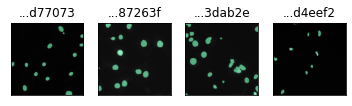

In [583]:
_path = "/home/data/02_SSD4TB/suzy/datasets/public/data-science-bowl-2018"
train_dataset = DSB18Dataset(_path, transform=None, download=False, show=True)

In [ ]:
#     def visualize_batch(self):
#         loader = DataLoader(self, shuffle=True, batch_size=4)
#         imgs = next(iter(loader))
#         inputs = torchvision.utils.make_grid(imgs)
#         plt.imshow(inputs.permute(1, 2, 0))

In [381]:
loader = DataLoader(train_dataset, shuffle=True, batch_size=4)
imgs, masks = next(iter(loader))

In [437]:
inputs = torchvision.utils.make_grid(imgs)
outputs = torchvision.utils.make_grid(masks)

batch_inputs_uint = convert_image_dtype(imgs, dtype=torch.uint8)
batch_outputs_bool = convert_image_dtype(masks, dtype=torch.bool)

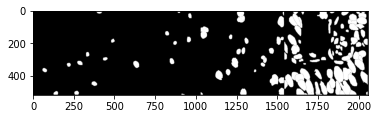

In [393]:
#plt.imshow(inputs.permute(1,2,0))
plt.imshow(outputs.permute(1,2,0).squeeze())

In [398]:
from torchvision.utils import draw_segmentation_masks
draw_segmentation_masks(inputs, masks=outputs)

ValueError: The image dtype must be uint8, got torch.float32

In [403]:
input_pils = F.to_pil_image(inputs)

def target
c620631271a56407d6d69fa1a69451ca99c50dcc30e29db04cf6fb7cacbde8cb.png
c1afe66cd139f996fd984f5f2622903730ec2f1192d90608154f07f7ef6cdb4b.png
30f65741053db713b3f328d31d3234b6fedbe31df65c1a8ea29be28146cab789.png
4e23ecf65040f86420e0201134e538951acdeda84fbb274311f995682044dd64.png


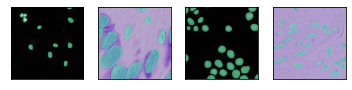

In [490]:
from torchvision.transforms.functional import convert_image_dtype

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
        
train_dataset = DSB18Dataset(_path, transform=None, download=False)

loader = DataLoader(train_dataset, shuffle=True, batch_size=4)
imgs, masks = next(iter(loader))


batch_inputs = convert_image_dtype(imgs, dtype=torch.uint8)
batch_outputs = convert_image_dtype(masks, dtype=torch.bool)

#grids = draw_segmentation_masks(batch_inputs, masks=batch_outputs)

dogs_with_masks = [
    draw_segmentation_masks(img, masks=mask, alpha=0.6, colors = (102,255,178))
    for img, mask in zip(batch_inputs, batch_outputs)
]

show(dogs_with_masks)

def target
a891bbc89143bca7a717386144eb061ec2d599cba24681389bcb3a2fedb8ff8c.png
ef6634efb46567d87b811be786b18c4cd0e2cda23d79b65d6afe0d259ef3ade6.png
20c37b1ad2f510ed7396969e855fe93d0d05611738f6e706e8ca1d1aed3ded45.png
b61d3fb0d0ebbee018346e0adeff9e9178f33aa95262779b3c196f93b4ace895.png


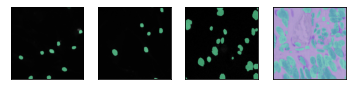

In [488]:
from torchvision.transforms.functional import convert_image_dtype


def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
        
        
train_dataset = DSB18Dataset(_path, transform=None, download=False)

loader = DataLoader(train_dataset, shuffle=True, batch_size=4)
imgs, masks = next(iter(loader))

inputs = torchvision.utils.make_grid(imgs)
outputs = torchvision.utils.make_grid(masks)

batch_inputs = convert_image_dtype(inputs, dtype=torch.uint8)
batch_outputs = convert_image_dtype(outputs, dtype=torch.bool)

#grids = draw_segmentation_masks(batch_inputs, masks=batch_outputs)

dogs_with_masks = [
    draw_segmentation_masks(img, masks=mask, alpha=0.6, colors = (102,255,178))
    for img, mask in zip(batch_inputs_uint, batch_outputs_bool)
]

show(dogs_with_masks)

In [407]:
outputs.dtype

torch.float64

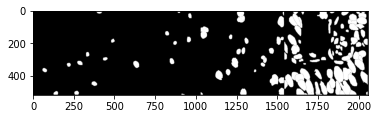

In [352]:
inputs.shape

torch.Size([3, 516, 2058])

In [351]:
outputs.shape

torch.Size([4, 512, 512])

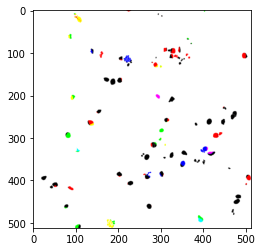

In [350]:
plt.imshow(outputs.permute(1,2,0))

In [318]:
masks.shape

torch.Size([4, 512, 512, 1])

In [287]:
inputs.shape

torch.Size([512, 516, 14])

In [284]:
imgs.shape

torch.Size([4, 3, 512, 512])

In [216]:
# create dataset object and get object

In [238]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
        
    print(len(imgs))
    #fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)

#     for i, img in enumerate(imgs):
#         img = F.to_pil_image(img)
#         img_np = np.asarray(img)
        
#         print(img_np.min(),img_np.max())
#         axs[0, i].imshow(img_np)
#         axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [239]:
# get the dataset and loader

In [244]:
_path = "/home/data/02_SSD4TB/suzy/datasets/public/data-science-bowl-2018"
train_dataset = DSB18Dataset(_path, transform=None, download=False)
loader = DataLoader(train_dataset, shuffle=True, batch_size=4)

imgs = next(iter(loader))
print(imgs.shape)
inputs = torchvision.utils.make_grid(imgs)
plt.imshow(inputs.permute(1, 2, 0))

def v
show(inputs)

d4d6c683f249d82518431603bf0206d05f2114ac871a99ffade0f5f61cf167e1.png
091944f1d2611c916b98c020bd066667e33f4639159b2a92407fe5a40788856d.png
1631352dbafb8a90f11219fffd3bea368a30bc3bad3bbe0e84e19bd720df4945.png
45cc00f2ef95da6698bf590663e319d7c0ed4fb99d42dd3cf4060887da74fb81.png
torch.Size([4, 3, 512, 512])
1


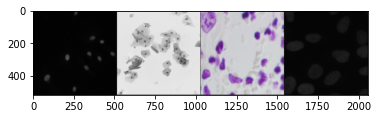

In [254]:
inputs.min()

tensor(0.)

In [249]:
inputs.shape

torch.Size([3, 516, 2058])

In [165]:
img_tensor = train_dataset.__getitem__(0)

inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
    std=[1/0.229, 1/0.224, 1/0.255]
)

inv_tensor = inv_normalize(img_tensor)
print(inv_tensor.max(), inv_tensor.min())

tensor(0.3194)
tensor(-1.9634) None
tensor(0.4875) tensor(-0.0140)


In [ ]:
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
    std=[1/0.229, 1/0.224, 1/0.255]
)

inv_tensor = inv_normalize(img)
print(inv_tensor.max(), inv_tensor.min())

img = F.to_pil_image(inv_tensor)
img_np = np.asarray(img)

In [149]:
train_dataset.__getitem__(0).min()

tensor(-1.9634)

In [83]:
inputs.dtype

torch.float32

In [53]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = imgs.tolist()
    print(len(imgs))
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)

    for i, img in enumerate(imgs):
        #img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [32]:
inputs.shape

torch.Size([4, 520, 696])

0
1
2
3


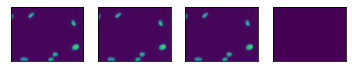

In [57]:
fix, axs = plt.subplots(ncols=len(inputs), squeeze=False)

for i, img in enumerate(inputs):
    print(i)
    img = F.to_pil_image(img)
    axs[0, i].imshow(np.asarray(img))
    axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [21]:
torchvision.utils.make_grid(inputs).shape

torch.Size([4, 520, 696])

In [15]:
inputs.shape

torch.Size([4, 520, 696])

4


TypeError: pic should be Tensor or ndarray. Got <class 'list'>.

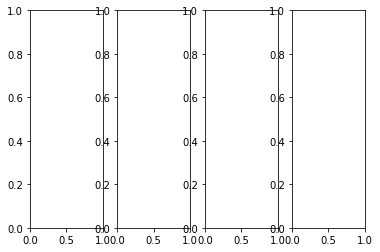

In [13]:
show(inputs)

In [25]:
len(inputs_list)

4

In [18]:
grid = torchvision.utils.make_grid(inputs)

1
i am instance
0


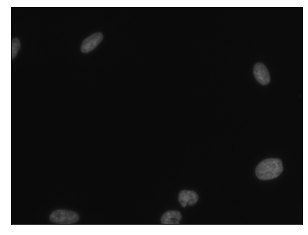

In [19]:
show(grid)

In [4]:
from torchvision.utils import draw_segmentation_masks

In [50]:
loader = DataLoader(train_dataset, shuffle=True, batch_size=4)
inputs, masks, fnames = next(iter(loader))

In [51]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [52]:
grid = torchvision.utils.make_grid([inputs[0], masks[0]])

RuntimeError: stack expects each tensor to be equal size, but got [3, 512, 512] at entry 0 and [1, 512, 512] at entry 1

In [57]:
inputs[0].shape

torch.Size([3, 512, 512])

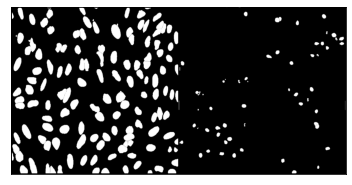

In [47]:
show(grid)

In [14]:
def format_image(img):

    img = np.array(np.transpose(img, (1, 2, 0)))
    mean = np.array((0.485, 0.456, 0.406))
    std = np.array((0.229, 0.224, 0.225))
    img = std * img + mean
    img = img*255
    img = img.astype(np.uint8)
    return img

In [26]:
hey_inputs = F.normalize(inputs, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

In [28]:
print(hey_inputs.shape, hey_inputs.min().item(), hey_inputs.max().item())

torch.Size([4, 3, 512, 512]) -11.291611671447754 9.864740371704102


In [29]:
normalized_masks = torch.nn.functional.softmax(hey_inputs, dim=1)

In [16]:
inputs.shape

torch.Size([4, 3, 512, 512])

In [23]:
hey_image

array([[[ 3,  3,  3],
        [ 3,  3,  3],
        [ 3,  3,  3],
        ...,
        [ 2,  2,  2],
        [ 2,  2,  2],
        [ 2,  2,  2]],

       [[ 3,  3,  3],
        [ 3,  3,  3],
        [ 3,  3,  3],
        ...,
        [ 2,  2,  2],
        [ 2,  2,  2],
        [ 2,  2,  2]],

       [[ 3,  3,  3],
        [ 3,  3,  3],
        [ 3,  3,  3],
        ...,
        [ 2,  2,  2],
        [ 2,  2,  2],
        [ 2,  2,  2]],

       ...,

       [[41, 41, 41],
        [41, 41, 41],
        [43, 43, 43],
        ...,
        [ 0,  1,  1],
        [ 0,  1,  1],
        [ 0,  1,  1]],

       [[38, 38, 38],
        [38, 38, 38],
        [39, 39, 39],
        ...,
        [ 0,  1,  1],
        [ 0,  1,  1],
        [ 0,  1,  1]],

       [[38, 38, 38],
        [38, 38, 38],
        [39, 39, 39],
        ...,
        [ 0,  1,  1],
        [ 0,  1,  1],
        [ 0,  1,  1]]], dtype=uint8)

In [22]:
hey_image = format_image(inputs[0])
hey_mask = masks[0]



TypeError: The image must be a tensor, got <class 'numpy.ndarray'>

In [128]:
draw_segmentation_masks

<function torchvision.utils.draw_segmentation_masks(image: torch.Tensor, masks: torch.Tensor, alpha: float = 0.8, colors: Union[List[Union[str, Tuple[int, int, int]]], NoneType] = None) -> torch.Tensor>

In [9]:
draw_segmentation_masks(inputs, masks)

ValueError: The image dtype must be uint8, got torch.float32

In [124]:

inputs = next(iter(loader))

/tmp/ipykernel_15524/274514211.py:67: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)


In [107]:
loader.__getitem__(0)

AttributeError: 'DataLoader' object has no attribute '__getitem__'

In [65]:
out = torchvision.utils.make_grid(inputs)

In [54]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

ValueError: pic should be 2/3 dimensional. Got 4 dimensions.

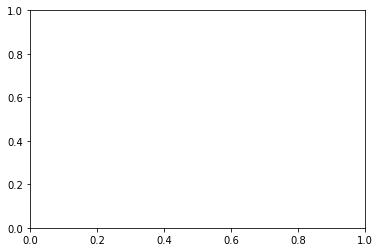

In [64]:
show(masks)

In [3]:
_path = "/home/data/02_SSD4TB/suzy/datasets/public/data-science-bowl-2018"
train_dataset = DSB18Dataset(_path, transform=None, download=False)
#train_dataset.visualize_dataset(5)

[130, 46, 477, 36, 170]


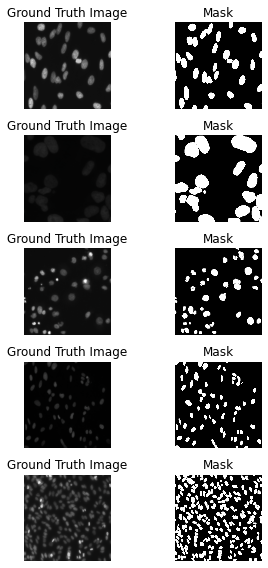

In [4]:
train_dataset = DSB18Dataset(_path, transform=None, download=False)
#train_dataset.visualize_dataset(5)

In [28]:
class DSB18Dataset0(Dataset):
    r"""PyTorch friendly DSB18Dataset class

    Dataset is loaded using Kaggle API.
    For further information on raw dataset and nuclei segmentation, please refer to [1]_.

    Examples
    ----------
    >>> train_dataset = DSB18Dataset(root=".", transform=None, download=False)
    >>> train_dataset.visualize_dataset(5)

    .. image:: ../imgs/DSB18Dataset.png
        :width: 300

    References
    ---------------
    .. [1] https://www.kaggle.com/c/data-science-bowl-2018/overview
    """

    def __init__(self, root: str = ".", download: bool = False, mode: str = "train", shape: int = 512, transform: transforms = None, target_transform: transforms = None, show: int = 5):
    
        tag = "data-science-bowl-2018"
        modes = ["train", "val"]
        assert mode in modes, "Available options for mode: train, val"

        path = os.path.join(root, tag, "stage1_train")
        if download:
            download_datasets(tag, path=root)
            extract_zip(os.path.join(root, tag+".zip"),
                        os.path.join(root, tag))
            extract_zip(os.path.join(root, tag, "stage1_train.zip"), path)
        else:
            path = os.path.join(root, "stage1_train")

        self.path = path

        if transform is None:
            self.transforms = self.default_transform(shape)

        self.folders = os.listdir(self.path)
        self.shape = shape
        #self.visualize_dataset(show)

    def __len__(self):
        return len(self.folders)

    def __getitem__(self, idx):
        image_folder = os.path.join(self.path, self.folders[idx], 'images/')
        mask_folder = os.path.join(self.path, self.folders[idx], 'masks/')
        fname = os.listdir(image_folder)[0]
        image_path = os.path.join(image_folder, fname)

        img = io.imread(image_path)[:, :, :3].astype('float32')
        img = transform.resize(img, (self.shape, self.shape))

        mask = self.get_mask(mask_folder, self.shape,
                             self.shape).astype('float32')

        augmented = self.transforms(image=img, mask=mask)
        img = augmented['image']
        mask = augmented['mask']

        mask = mask.permute(2, 0, 1)
        return (img, mask, fname)

    def get_mask(self, mask_folder, IMG_HEIGHT, IMG_WIDTH):
        mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
        for mask_ in os.listdir(mask_folder):
            mask_ = io.imread(os.path.join(mask_folder, mask_))
            mask_ = transform.resize(mask_, (IMG_HEIGHT, IMG_WIDTH))
            mask_ = np.expand_dims(mask_, axis=-1)
            mask = np.maximum(mask, mask_)

        return mask

    def default_transform(self, img_shape):
        return A.Compose([
            A.Resize(img_shape, img_shape),
            A.Normalize(mean=(0.485, 0.456, 0.406),
                        std=(0.229, 0.224, 0.225)),
            A.HorizontalFlip(p=0.25),
            A.VerticalFlip(p=0.25),
            ToTensorV2()
        ])

#     def visualize_dataset(self, n_images, predict=None):
#         """
#         Function to visualize images and masks
#         """
#         images = random.sample(range(0, 670), n_images)
#         figure, ax = plt.subplots(nrows=len(images), ncols=2, figsize=(5, 8))
#         for i in range(0, len(images)):
#             img_no = images[i]
#             image, mask, fname = self.__getitem__(img_no)
#             image = self.format_image(image)
#             mask = self.format_mask(mask)
#             ax[i, 0].imshow(image)
#             ax[i, 1].imshow(mask, interpolation="nearest", cmap="gray")
#             ax[i, 0].set_title("Ground Truth Image")
#             ax[i, 1].set_title("Mask")
#             ax[i, 0].set_axis_off()
#             ax[i, 1].set_axis_off()
#             plt.tight_layout()

#         return plt

#     @staticmethod
#     def format_image(img):
#         img = np.array(np.transpose(img, (1, 2, 0)))
#         mean = np.array((0.485, 0.456, 0.406))
#         std = np.array((0.229, 0.224, 0.225))
#         img = std * img + mean
#         img = img*255
#         img = img.astype(np.uint8)
#         return img

#     @staticmethod
#     def format_mask(mask):
#         mask = np.squeeze(np.transpose(mask, (1, 2, 0)))
#         return mask

In [29]:
_path = "/home/data/02_SSD4TB/suzy/datasets/public/data-science-bowl-2018"
train_dataset = DSB18Dataset0(_path, transform=None, download=False)
#train_dataset.visualize_dataset(5)

In [30]:
loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

In [31]:
next(iter(loader))

/tmp/ipykernel_15331/114469613.py:67: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)


[tensor([[[[-1.9326, -1.9374, -1.9295,  ..., -1.9143, -1.9217, -1.9264],
           [-1.9296, -1.9297, -1.9295,  ..., -1.9295, -1.9295, -1.9158],
           [-1.9325, -1.9371, -1.9301,  ..., -1.9295, -1.9292, -1.9289],
           ...,
           [-1.9465, -1.9463, -1.9467,  ..., -1.8970, -1.9124, -1.9119],
           [-1.9467, -1.9467, -1.9316,  ..., -1.8953, -1.9034, -1.8987],
           [-1.9327, -1.9375, -1.9448,  ..., -1.9105, -1.9032, -1.8984]],
 
          [[-1.8463, -1.8511, -1.8431,  ..., -1.8275, -1.8351, -1.8399],
           [-1.8432, -1.8433, -1.8431,  ..., -1.8431, -1.8431, -1.8291],
           [-1.8462, -1.8509, -1.8438,  ..., -1.8431, -1.8428, -1.8425],
           ...,
           [-1.8605, -1.8603, -1.8606,  ..., -1.8099, -1.8256, -1.8251],
           [-1.8606, -1.8606, -1.8453,  ..., -1.8082, -1.8164, -1.8116],
           [-1.8464, -1.8513, -1.8588,  ..., -1.8237, -1.8162, -1.8113]],
 
          [[-1.6158, -1.6207, -1.6127,  ..., -1.5972, -1.6048, -1.6095],
           [-

In [ ]:
@staticmethod
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    fig = plt.gcf()
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    return fig

def visualize_dataset(self, show):
    loader = DataLoader(self, batch_size=show, shuffle=True)
    inputs, classes = next(iter(loader))
    class_names = self.classes
    out = torchvision.utils.make_grid(inputs)
    self.imshow(out, title=[class_names[x] for x in classes])

In [4]:
loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

In [20]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    fig = plt.gcf()
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    return fig

In [24]:
img, mask, fname = next(iter(loader))

out = torchvision.utils.make_grid(img, mask)
imshow(out)

RuntimeError: Boolean value of Tensor with more than one value is ambiguous

In [23]:
img.shape

torch.Size([4, 3, 512, 512])

In [15]:
out

tensor([[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000, -1.6941,  ..., -1.8064,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000, -2.0155,  ..., -1.3912,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000, -1.6025,  ..., -1.7173,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000, -1.9311,  ..., -1.2928,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0

In [13]:
#next(iter(loader))

In [1]:
_path = "/home/data/02_SSD4TB/suzy/datasets/public/chest-xray"
#_path = "/home/data/02_SSD4TB/suzy/datasets/public/testy"

valid_dataset = ChestXrayDataset(root=_path, download=False, mode="val", show=True)
#valid_dataset.visualize_dataset()

NameError: name 'ChestXrayDataset' is not defined

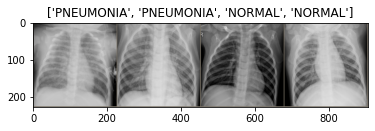

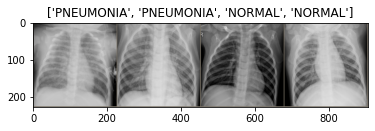

In [2]:
import os
import torchvision
from farabio.data.biodatasets import ChestXrayDataset
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np

_path = "/home/data/02_SSD4TB/suzy/datasets/public/chest-xray"
#_path = "/home/data/02_SSD4TB/suzy/datasets/public/testy"

valid_dataset = ChestXrayDataset(root=_path, download=False, mode="val")
#valid_dataset.visualize_dataset()

#print(valid_dataset.__getitem__(0)[0])
train_loader = DataLoader(valid_dataset, batch_size=4, shuffle=True)
inputs, classes = next(iter(train_loader))
class_names = valid_dataset.classes

#inputs, classes = next(iter(train_loader))
out = torchvision.utils.make_grid(inputs)

def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    fig = plt.gcf()
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    return fig

imshow(out, title=[class_names[x] for x in classes])